In [1]:
%load_ext autoreload
%autoreload 2

from PIL import Image
import torch
import numpy as np

from generate_dataset import ring_dataset
from train_model import train_model

import matplotlib.pyplot as plt

/home/juluis/anaconda3/envs/ImageGeneration/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EPOCH 3...


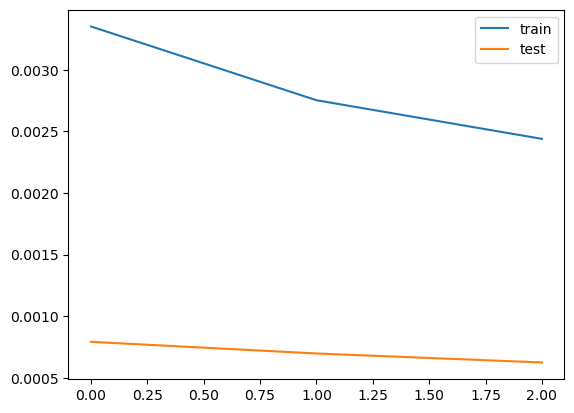

KeyboardInterrupt: 

In [27]:
generator, train_loss, test_loss, ring_gen = train_model('Conv', model=generator, data_size=10000, epochs=20, batch_size=128, lr=1e-3)

In [3]:
test_loss

[0.019536892883479595,
 0.018935132306069136,
 0.01673661492532119,
 0.010642681852914393,
 0.008802028838545084,
 0.006011371937347576,
 0.0041132320038741454,
 0.0035623401490738615,
 0.003131156656309031,
 0.002899074141168967,
 0.0026569928595563397,
 0.0025182096287608147,
 0.002359675694606267,
 0.0022563003294635564,
 0.002136965616955422,
 0.0020441491578822024,
 0.001941437934874557,
 0.001860137126641348,
 0.0017824556562118232,
 0.001719640706141945]

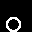

In [25]:
features, img = ring_gen.random_ring()
Image.fromarray(img)

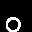

In [26]:
img_pred = generator(features).detach().numpy().squeeze() > 0.5
Image.fromarray(img_pred)

In [ ]:
img = generator(torch.tensor([[15, 15, 5, 10]], dtype=torch.float)).detach().numpy().squeeze()

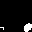

In [55]:
Image.fromarray(img)

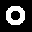

In [57]:
Image.fromarray(create_ring_img(32, (15, 15), 5, 10))

In [61]:
def create_ring_img(N, center, inner, outer):
    img_coor = [[(i, j) for i in range(N)] for j in range(N)]
    radius = np.linalg.norm(np.array(img_coor) - center, axis=2)
    img = np.zeros(radius.shape, dtype=np.bool)
    for i in range(N):
        for j in range(N):
            if radius[i, j] >= inner and radius[i, j] < outer:
                img[i, j] = 1

    return img